In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

In this Jupyter notebook, I have implemented my own generative classifier for classification tasks. Initially, I evaluated its performance on a digit dataset, where it performed very well. Subsequently, I utilized this classifier to generate new data, specifically new photos of George W. Bush and new digit images.

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.mixture import GaussianMixture

class GMMClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on GaussianMixture
    
    Parameters
    ----------
    n_components : int, default=10
        numbers of GM components used within each class
    covariance_type : str, default='full'
        covariance type name, passed to GaussianMixture
    """
    def __init__(self, n_components=10, covariance_type = 'full'):
        self.n_components = n_components
        self.covariance_type = covariance_type
        
    def fit(self, X, y):
        """Creates a generative model for each class and calculates 
            priors probabilites P(y).
            
        Parameters
        ----------
        X : Data to train on 
        y : Labels
        
        Returns
        -------
        self
        """
        #find disticnct classes
        self.classes_ = np.sort(np.unique(y))
        #split the data by classes
        training_sets = [X[y==yi] for yi in self.classes_]
        #built a generative model for each class
        self.models_ = [GaussianMixture(n_components=self.n_components, covariance_type=self.covariance_type).fit(Xi)
                       for Xi in training_sets]
        # calculate priors probabilites p(y)'s
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0]) for Xi in training_sets]
        return self #for chain operations
    
    def predict_proba(self, X):
        """Assigns probability of being a member of each class
        Parameters
        ----------
        X : Data
        Returns
        -------
        Array of probabilities of being a member of each class
        """
        logprobs = np.array([model.score_samples(X) for model in self.models_]).T
        #small value to make sure that division by 0 won't appear
        epsilon = 1e-10
        result = np.exp(logprobs + self.logpriors_)
        return result / (result.sum(1, keepdims=True)+epsilon)
    
    def get_sample(self, label):
        """Generate a new sample of the data with the help of generative models trained for each 
        class
        
        Parameters
        ----------
        label : label for each class
        Returns
        -------
        sample of new, generated data
        """
        if np.isin(label, self.classes_):
            Xnew = self.models_[label].sample(1)
            return Xnew
    
    def predict(self, X):
        """Predicts a label for the data
        Returns: label"""
        return self.classes_[np.argmax(self.predict_proba(X), 1)]
        

In [3]:
#lets try to use the model to find labels for numbers

In [4]:
#import data
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
digits = load_digits()

#split data into train and test sets
from sklearn.model_selection import train_test_split
Ncomponents_arr = [1,2,3,4,5,6,7]
grid = GridSearchCV(GMMClassifier(), {'n_components': Ncomponents_arr})
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,random_state=0)


grid.fit(Xtrain,ytrain)

GridSearchCV(estimator=GMMClassifier(),
             param_grid={'n_components': [1, 2, 3, 4, 5, 6, 7]})

In [5]:
from sklearn.metrics import accuracy_score

model = grid.best_estimator_


yGMM = model.predict(Xtest)

print("Accuracy Score for digits: ", accuracy_score(y_true=ytest, y_pred=yGMM))

Accuracy Score for digits:  0.9511111111111111


In [6]:
print(grid.best_params_)

{'n_components': 1}


Text(0.5, 1.0, 'Classification Performance Evaluation \n of GMMClassifier on the Digits Dataset')

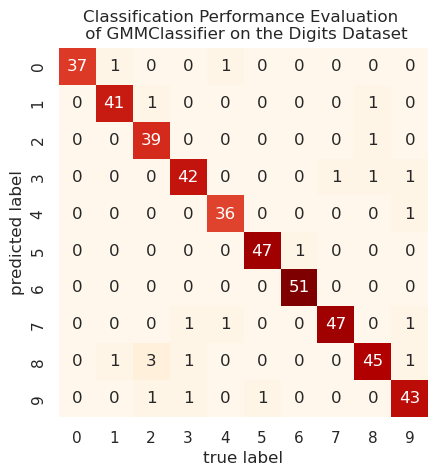

In [7]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, yGMM)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='OrRd')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Classification Performance Evaluation \n of GMMClassifier on the Digits Dataset")

With the digit dataset, my model achieved an accuracy of 95%. As can be observed from the image displayed above, it makes errors very rarely.  
Now, I will proceed to generate new digit images using this trained model.

Examples of digits generated by GMM generative models:


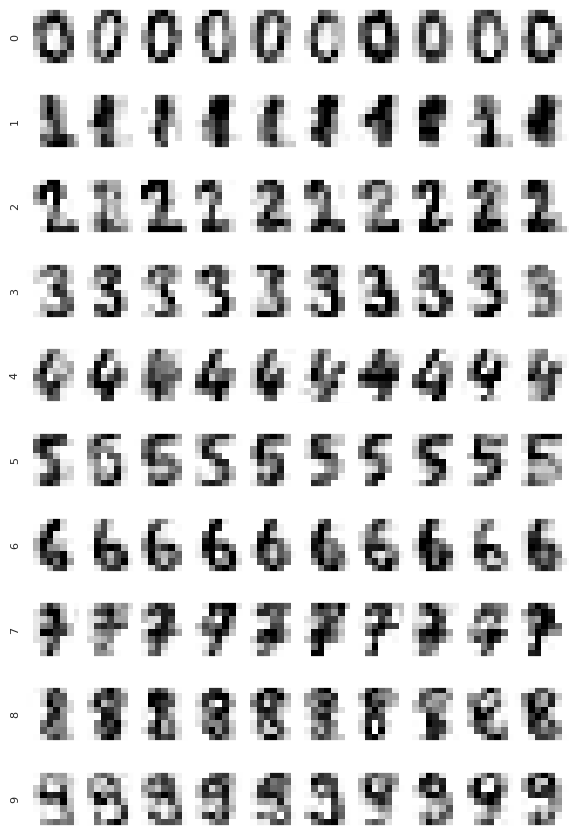

In [8]:

#Plotting example photos
# Create subplots for the images
fig, ax = plt.subplots(10, 10, figsize=(7, 11))
fig.subplots_adjust(hspace=0, wspace=0)

print("Examples of digits generated by GMM generative models:")

for j in range(10):
    for i in range(10):
        ax[j, 0].set_ylabel(str(j),fontsize=8)
        # Remove both x and y ticks
        ax[j, i].xaxis.set_major_locator(plt.NullLocator())
        ax[j, i].yaxis.set_major_locator(plt.NullLocator())
        
        #generate sample and show it
        A1 = model.get_sample(j)  # Only take the first element of the tuple 
        im = ax[j, i].imshow(A1[0].reshape(8,8), cmap="binary")
        im.set_clim(0,16)

plt.show()

Lets see how it will work on faces data

In [9]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=300)
print("Shape of images: " + str(faces.images.shape))
print("Target people:\n " + str(faces.target_names))

Shape of images: (530, 62, 47)
Target people:
 ['George W Bush']


I will now proceed to evaluate the generative capabilities of my model by producing new images of George W. Bush.

Examples of photos on which I am working: 


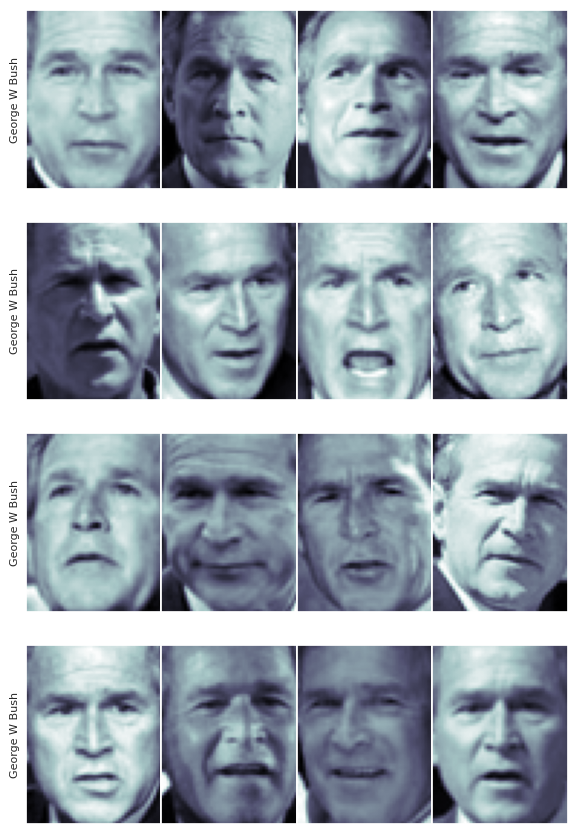

In [10]:
#showing examples of photos from the data set

fig, ax = plt.subplots(4, 4,figsize=(7, 11))
fig.subplots_adjust(hspace=0, wspace=0)

print("Examples of photos on which I am working: ")

# Loop through the subplots to display sample images
for j in range(4):
    # Set the y-label to the target name
    ax[j, 0].set_ylabel(faces.target_names[0], fontsize=8)
    
    for i in range(4):
        # Remove both x and y ticks for a cleaner display
        ax[j, i].xaxis.set_major_locator(plt.NullLocator())
        ax[j, i].yaxis.set_major_locator(plt.NullLocator())
        
        # Display the image corresponding to the current target and index
        idx = j * 4 + i  # Calculate the index based on j and i
        ax[j, i].imshow(faces.images[idx], cmap="bone")

plt.show()


In normal cirumstances I would reduce the number of dimesnisons with the PCA alghoritm but I just want to see how photos generated by the model will look like.

In [11]:
gmmcBushmodel = GMMClassifier(n_components=1, covariance_type='full')
gmmcBushmodel.fit(faces.data, faces.target)

GMMClassifier(n_components=1)

Examples of faces generated by GMM generative models:


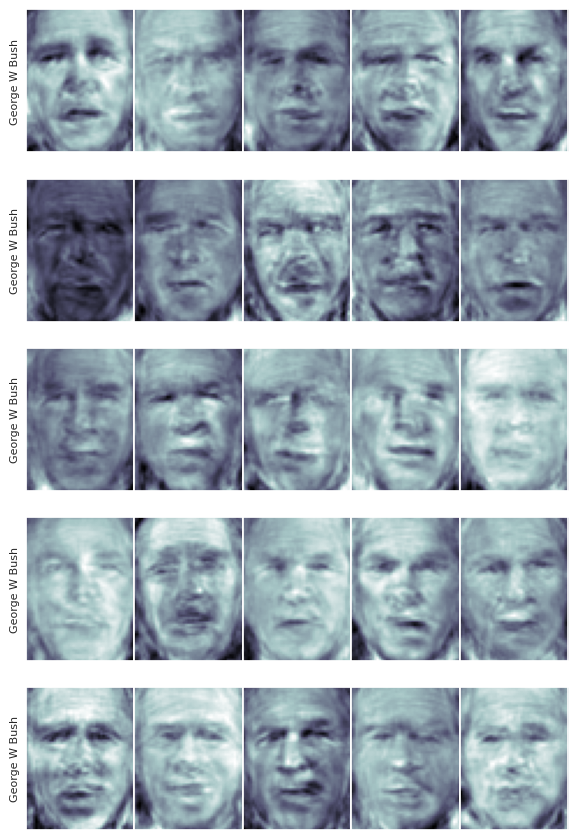

In [22]:

#Plotting example photos
# Create subplots for the images
fig, ax = plt.subplots(5, 5, figsize=(7, 11))
fig.subplots_adjust(hspace=0, wspace=0)

print("Examples of faces generated by GMM generative models:")

for j in range(5):
    for i in range(5):
        ax[j, 0].set_ylabel('George W Bush',fontsize=8)
        # Remove both x and y ticks
        ax[j, i].xaxis.set_major_locator(plt.NullLocator())
        ax[j, i].yaxis.set_major_locator(plt.NullLocator())
        
        #generate sample and show it
        A1 = gmmcBushmodel.get_sample(0)  # Only take the first element of the tuple 
        im = ax[j, i].imshow(A1[0].reshape(62,47), cmap="bone")

plt.show()

So my classifier does a pretty good job of generating easy images like numbers, but performs poorly when tasked with generating new photos of Bush.